# Titanic data analysis
The purpose of this report is to perform an analysis of the Titanic passengers data and create a machine learning model to predict the passenger's chances of surviving the disaster.  

I will train a few classifiers, which were introduced in Intel's Machine Learning Course and compare their performance.

Importing packages:

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Loading datasets to pandas DataFrames:

In [135]:
# Importing the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Let's display some information about the data:

In [136]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [139]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We should not look at the training data, so we only display the information about missing values. We will prepare the data based on training set and just make the same changes to test set, so it fits the model.  

We can also visualise missing data by heatmap:

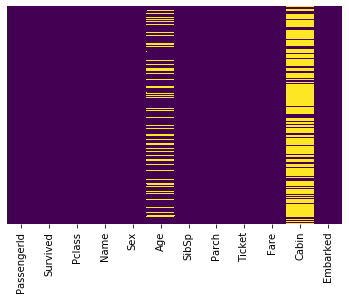

In [140]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Data exploration and preparation

Let's take care of every feature in the dataset to make it usefull for the prediction model.

## Passenger Id
We can assume, that "PassengerID" column has no correlation with surviving the disaster, so we can drop this collumn.

In [141]:
train_df = train_df.drop("PassengerId", axis = 1)
#test_df = test_df.drop("PassengerId", axis = 1)

## Pclass
We can see, that "Pclass" is a numerical, categorical feature with three possible values and no values are missing, so we don't have to change anything. Let's see how this feature impact surviving:

In [142]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


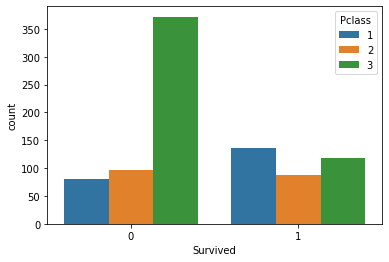

In [143]:
sns.countplot(x='Survived', hue='Pclass', data=train_df)

There is a strong correlation - third class passengers were less likely to have survived.  

Now we scale these values so they are between 0 and 1:

In [144]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train_df[["Pclass"]] = min_max_scaler.fit_transform(train_df[["Pclass"]])
test_df[["Pclass"]] = min_max_scaler.fit_transform(test_df[["Pclass"]])

## Name
"Name" feature itself has no correlation with survivng and also the values are of different formats (some contain second names or titles). We could drop this feature but we can also try to get title from names and create the new feature from it.

In [145]:
import re as re  # package for regular expressions

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

train_df['Title'] = train_df['Name'].apply(get_title)
test_df['Title'] = test_df['Name'].apply(get_title)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We have a lot of values of "Title" feature, but some of them occure very rarely and some of them have similar meaning (for ex.: "Ms" and "Miss").

In [146]:
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


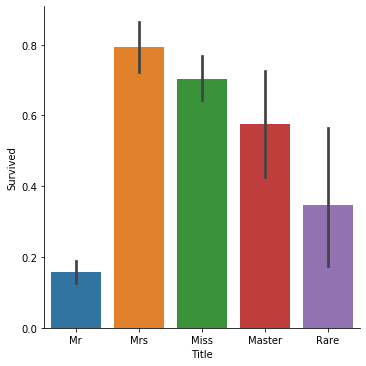

In [147]:
sns.catplot(x = "Title", y = "Survived", kind = "bar", data = train_df)

Now we have to map titles into dummy numerical values. We can not just map titles into values like 1,2,3,4,5, because this may suggest graduation of titles to the predictor, which is undesirable.

In [148]:
# Trainig set:
dummy = pd.get_dummies(train_df["Title"])
train_df = pd.concat([train_df, dummy], axis = 1)

#Test set:
dummy = pd.get_dummies(test_df["Title"])
test_df = pd.concat([test_df, dummy], axis = 1)

Now we can drop "Name" and "Title" column:

In [149]:
train_df = train_df.drop(["Name", "Title"], axis = 1)
test_df = test_df.drop(["Name", "Title"], axis = 1)

## Sex

In [150]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


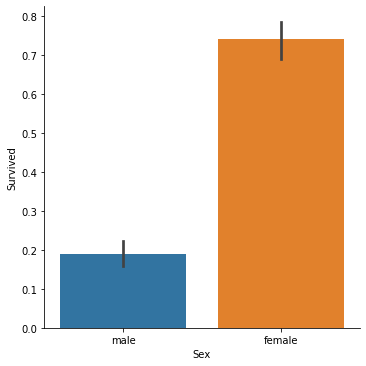

In [151]:
sns.catplot(x = "Sex", y = "Survived", kind = "bar", data = train_df)

It is clear, that females were more likely to have survived, which was also possible to observe in "Title" feature.
Values of "Sex" feature are categorical, but not numerical, so we only have to map them.

In [152]:
train_df['Sex'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_df['Sex'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

train_df = train_df.rename(columns={'Sex': 'Male'})
test_df = test_df.rename(columns={'Sex': 'Male'})

The feature was rename to "Male" so 0 and 1 values are more clear to read.

## Age
First of all, there are some missing values of this feature. The simplest method of filling them is to generate random values between (mean - std) and (mean + std). This is not the best solutions, but it shouldn't change this feature's impact on predictions, so we just use it.

In [153]:
# Training set:
train_age_avg = train_df['Age'].mean()
train_age_std = train_df['Age'].std()
train_age_null_count = train_df['Age'].isnull().sum()

train_age_random_list = np.random.randint(train_age_avg - train_age_std, train_age_avg + train_age_std, 
                                          size=train_age_null_count)
train_df['Age'][np.isnan(train_df['Age'])] = train_age_random_list
train_df['Age'] = train_df['Age'].astype(int)

# Test set:
test_age_avg = test_df['Age'].mean()
test_age_std = test_df['Age'].std()
test_age_null_count = test_df['Age'].isnull().sum()

test_age_random_list = np.random.randint(test_age_avg - test_age_std, test_age_avg + test_age_std, 
                                          size=test_age_null_count)
test_df['Age'][np.isnan(test_df['Age'])] = test_age_random_list
test_df['Age'] = test_df['Age'].astype(int)

Lets see the missing values heatmap again:

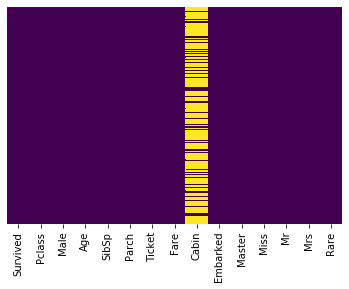

In [154]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Lets see the distibution of "Age" feature:

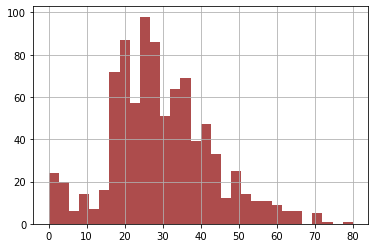

In [155]:
train_df['Age'].hist(bins=30,color='darkred',alpha=0.7)

Now we categorize values of "Age" into 5 intervals to explore the correlations:

In [156]:
train_df['CategoricalAge'] = pd.cut(train_df['Age'], 5)

train_df[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.546296
1,"(16.0, 32.0]",0.355408
2,"(32.0, 48.0]",0.364000
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


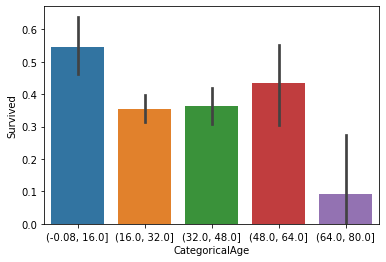

In [157]:
sns.barplot(x="CategoricalAge", y="Survived", data = train_df)

We can see that the highest survival propbability was for passengers younger than 16 and the lowest for older than 64.  

Combinig this information with the conclusions from "Sex" feature exploration, we can see, that women and children were rescued in the first place.

Now we drop "CategoricalAge" column.

In [158]:
train_df = train_df.drop('CategoricalAge', axis = 1)

Now we scale "Age" values, so they are in range <0, 1>:

In [159]:
train_df[["Age"]] = min_max_scaler.fit_transform(train_df[["Age"]])
test_df[["Age"]] = min_max_scaler.fit_transform(test_df[["Age"]])

## SibSp and Parch
SibSp - number of Siblings/Spouses aboard
Parch - number of Parents/Children aboard

We can converse these two features into one feature discribing family size onboard:

In [160]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


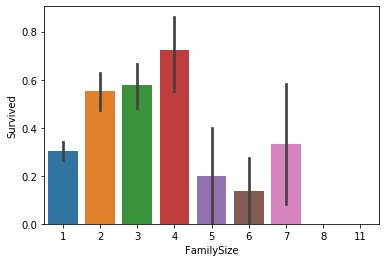

In [161]:
sns.barplot(x="FamilySize", y="Survived", data=train_df)

There is no obvious correlation visible, so we can try to categorize passengers based on the information if they were onboard alone or with family:

In [162]:
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

test_df['IsAlone'] = 0
test_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


People with family members onboard were more likely to have survived.  
Lets drop unnecessary columns:

In [163]:
train_df = train_df.drop(["SibSp", "Parch", "FamilySize"], axis = 1)
test_df = test_df.drop(["SibSp", "Parch", "FamilySize"], axis = 1)

## Ticket and Cabin

In [164]:
train_df.describe(include=['O'])

,Ticket,Cabin,Embarked
count,891,204,889
unique,681,147,3
top,347082,G6,S
freq,7,4,644


Majority of "Cabin" feature is missing values, so we can drop this column entirely as there is no way to complete the values reasonably.  

"Ticket" collumn contain 681 unique values, some of with are numerical and some are alphanumerical. These values are just random ticket numbers and have no correlation with survival, so we also drop this feature.

In [165]:
train_df = train_df.drop(["Cabin", "Ticket"], axis = 1)
test_df = test_df.drop(["Cabin", "Ticket"], axis = 1)

Heatmap of missing values:

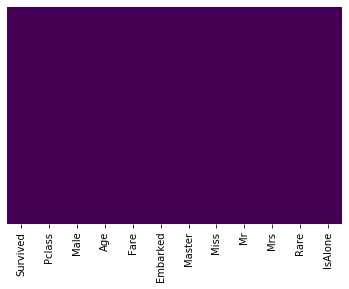

In [166]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Fare
There is one missing value in test set. We will just replace it with the median:

In [167]:
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

Lets see the distribution of fare feature:

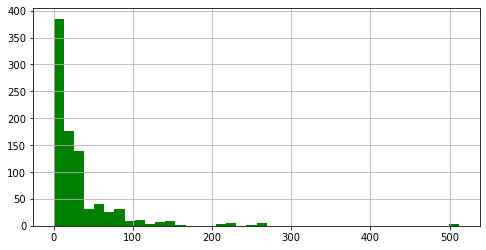

In [168]:
train_df['Fare'].hist(color='green',bins=40,figsize=(8,4))

Now we scale values of "Fare":

In [169]:
train_df[["Fare"]] = min_max_scaler.fit_transform(train_df[["Fare"]])
test_df[["Fare"]] = min_max_scaler.fit_transform(test_df[["Fare"]])

## Embarked
C = Cherbourg; Q = Queenstown; S = Southampton  

In [170]:
train_df["Embarked"].isnull().sum()

2

There are 2 missing values in trainig set. We will just drop these rows.

In [171]:
train_df.dropna(inplace=True)

train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


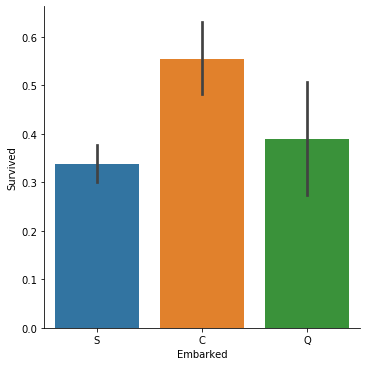

In [172]:
sns.catplot(x="Embarked", y="Survived", kind="bar", data=train_df)

We can see, that people who embarked in Cherbourg were most likely to have survived.  

Now we have to create dummy values:

In [173]:
# Trainig set:
dummy = pd.get_dummies(train_df["Embarked"])
train_df = pd.concat([train_df, dummy], axis = 1)

#Test set:
dummy = pd.get_dummies(test_df["Embarked"])
test_df = pd.concat([test_df, dummy], axis = 1)

train_df = train_df.drop("Embarked", axis = 1)
test_df = test_df.drop("Embarked", axis = 1)

Lets see the final dataframe:

In [174]:
train_df

,Survived,Pclass,Male,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,C,Q,S
0,0,1.0,1,0.2750,0.014151,0,0,1,0,0,0,0,0,1
1,1,0.0,0,0.4750,0.139136,0,0,0,1,0,0,1,0,0
2,1,1.0,0,0.3250,0.015469,0,1,0,0,0,1,0,0,1
3,1,0.0,0,0.4375,0.103644,0,0,0,1,0,0,0,0,1
4,0,1.0,1,0.4375,0.015713,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.5,1,0.3375,0.025374,0,0,0,0,1,1,0,0,1
887,1,0.0,0,0.2375,0.058556,0,1,0,0,0,1,0,0,1
888,0,1.0,0,0.4125,0.045771,0,1,0,0,0,0,0,0,1
889,1,0.0,1,0.3250,0.058556,0,0,1,0,0,1,1,0,0


In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
Survived    889 non-null int64
Pclass      889 non-null float64
Male        889 non-null int32
Age         889 non-null float64
Fare        889 non-null float64
Master      889 non-null uint8
Miss        889 non-null uint8
Mr          889 non-null uint8
Mrs         889 non-null uint8
Rare        889 non-null uint8
IsAlone     889 non-null int64
C           889 non-null uint8
Q           889 non-null uint8
S           889 non-null uint8
dtypes: float64(3), int32(1), int64(2), uint8(8)
memory usage: 92.1 KB


In [176]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null float64
Male           418 non-null int32
Age            418 non-null float64
Fare           418 non-null float64
Master         418 non-null uint8
Miss           418 non-null uint8
Mr             418 non-null uint8
Mrs            418 non-null uint8
Rare           418 non-null uint8
IsAlone        418 non-null int64
C              418 non-null uint8
Q              418 non-null uint8
S              418 non-null uint8
dtypes: float64(3), int32(1), int64(2), uint8(8)
memory usage: 21.4 KB


# Creating classifiers

Provided "test.csv" file is used for evaluating the model performance on Kaggle competition, so it does not contain "Survived" column.  
The "gender_submission.csv" file is just an example of how the predictions should be submitted on Kaggle. The value of "Survived" in this file is just based on gender (male - 0, female - 1).  
So to evaluate my models locally I will split train_df into train and test set.

Train and test split:

In [177]:
y = train_df["Survived"]
X = train_df.drop("Survived", axis = 1)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

## Logistic regression

In [178]:
from sklearn.linear_model import LogisticRegression

Creating and training the model:

In [179]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

Making predictions:

In [180]:
predictions = logmodel.predict(X_test)

Evaluating the model:

In [181]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [182]:
accuracy_score(y_test, predictions)

0.8089887640449438

In [183]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       167
           1       0.73      0.78      0.75       100

    accuracy                           0.81       267
   macro avg       0.80      0.80      0.80       267
weighted avg       0.81      0.81      0.81       267



In [184]:
print(confusion_matrix(y_test,predictions))

[[138  29]
 [ 22  78]]


## Decision tree classifier

In [185]:
from sklearn.tree import DecisionTreeClassifier

In [186]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

DecisionTreeClassifier()

In [187]:
predictions = DTC.predict(X_test)

In [188]:
accuracy_score(y_test, predictions)

0.7378277153558053

## Random forest classifier

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [191]:
predictions = RFC.predict(X_test)

In [192]:
accuracy_score(y_test, predictions)

0.7715355805243446

## Support vector machine classifier

In [193]:
from sklearn.svm import SVC

In [194]:
SVM = SVC()


In [195]:
SVM.fit(X_train, y_train)

SVC()

In [196]:
predictions = SVM.predict(X_test)

In [197]:
accuracy_score(y_test, predictions)

0.8052434456928839

## K Neighbours classifier

In [198]:
from sklearn.neighbors import KNeighborsClassifier

In [199]:
KNC = KNeighborsClassifier()
KNC.fit(X_train, y_train)

KNeighborsClassifier()

In [200]:
predictions = KNC.predict(X_test)

In [201]:
accuracy_score(y_test, predictions)

0.7940074906367042

## Gaussian Naive Bayes classifier

In [202]:
from sklearn.naive_bayes import GaussianNB

In [203]:
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB()

In [204]:
predictions = NB.predict(X_test)

In [205]:
accuracy_score(y_test, predictions)

0.7677902621722846

## Gradient boosting classifier

In [206]:
from sklearn.ensemble import GradientBoostingClassifier

In [207]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

GradientBoostingClassifier()

In [208]:
predictions = GBC.predict(X_test)

In [209]:
accuracy_score(y_test, predictions)

0.8127340823970037

## AdaBoost classifier

In [210]:
from sklearn.ensemble import AdaBoostClassifier

In [211]:
ABC = AdaBoostClassifier()
ABC.fit(X_train, y_train)

AdaBoostClassifier()

In [212]:
predictions = ABC.predict(X_test)

In [213]:
accuracy_score(y_test, predictions)

0.8202247191011236

# Comparison

Text(0, 0.5, 'Classifier')

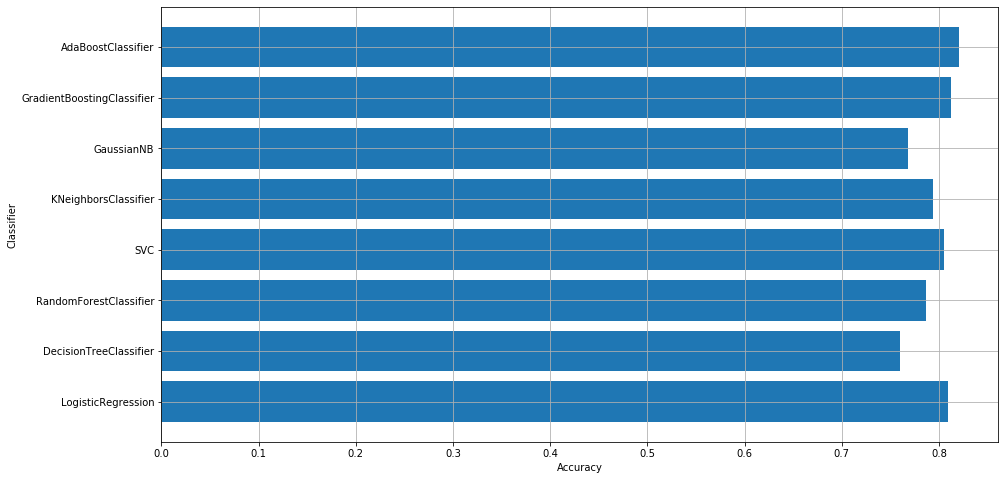

In [214]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), 
          KNeighborsClassifier(), GaussianNB(), GradientBoostingClassifier(), 
          AdaBoostClassifier()]

evaluation = {}

for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    name = model.__class__.__name__
    evaluation[name] = acc  

plt.figure(figsize = (15,8))
plt.barh(range(len(evaluation)), list(evaluation.values()), align='center', tick_label = list(evaluation.keys()))
plt.grid()
plt.xlabel("Accuracy")
plt.ylabel("Classifier")

Creating predictions with the best classifiers for 'test.csv' data and exporting it for evaluation at Kaggle:

In [215]:
predictions = SVM.predict(test_df.drop("PassengerId", axis = 1))
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('SVM_submission.csv', index=False)

In [216]:
predictions = ABC.predict(test_df.drop("PassengerId", axis = 1))
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('ABC_submission.csv', index=False)

In [217]:
predictions = GBC.predict(test_df.drop("PassengerId", axis = 1))
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('GBC_submission.csv', index=False)

In [218]:
predictions = logmodel.predict(test_df.drop("PassengerId", axis = 1))
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('logmodel_submission.csv', index=False)

Results from Kaggle competition:  


Model | Accuracy 
--- | --- 
Support Vector Classifier | 0.78468
AdaBoost Classifier | 0.74401
Gradient Boosting Classifier | 0.77033
Logistic Regression | 0.75837

# Conclusions

Support Vector Machine Classifier seem to word the best for the Titanic dataset, but it could still be improved.
First of all, the data was prepared to have been used for every classifier. All of them work differently and have different specification, so dataset could be prepared separately for each algorithm to fit its needs. What is more, every model was trained with default values of hyperparameters. The next step would be choosing one predictor and tuning hyperparameters values, for example with Grid Search Cross-Validation. This could improve performance of the model.